In [1]:
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid.inset_locator import inset_axes

In [2]:
reports = ['v05_Rac1_dominant', 
           'v05_RhoA_dominant',
           'v05_equal_oscillations']
files = ['reports/{}/base/special_basins.txt'.format(r) for r in reports]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b",
    "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

In [3]:
def parse_raw_basins(raw):
#     TODO: deal with empty text in first column (repeated from previous)
    
    import re
    lines = raw.split("\n")[1:]    
    names = re.findall('\S+', lines[0])
    basins = []
    values = []    
    for line in lines[1:]:        
        if not re.match(r"[01]*\s+[01]+\s+\d+\s+[\d.]+", line):
            continue        
        
        if line.startswith(" "):
            # from previous line
            line = cols[0] + line
        cols = re.findall('\S+', line)
        values.append(float(cols[3]))
        a = cols[0]
        b = cols[1]
        max_len = max(len(a), len(b))        
        a = a*max_len
        b = b*max_len
        cycle = []
        for i in range(max_len):
            cycle.append(a[i]+b[i])
        
        basins.append("\n".join(cycle))
        
    return names, basins, values

In [4]:
def add_annotation(ax, names, x, y, text_offset=20):
    ax.annotate(names[0], xy=(x-0.05, y), 
            textcoords='offset points',
            xytext=(-1, text_offset), 
            arrowprops=dict(arrowstyle='->'), 
            horizontalalignment='right')
    ax.annotate(names[1], xy=(x + 0.05, y), 
            textcoords='offset points',
            xytext=(1, text_offset), 
            arrowprops=dict(arrowstyle='->'),             
            horizontalalignment='left')
        
def get_activity(report):
    import csv
    reader = csv.reader(open('reports/{}/base/weighted_activity.csv'.format(report), 'r'))
    act = {}
    for data in reader:        
        act[data[0]] = data[1]
        
    return act

In [5]:
def transform_basins(basins, values):
    oscillations_label = 'osc'
    basins_t = {'11':0.0, '10':0.0, '01':0.0, '00':0.0, oscillations_label:0.0}
    order = ['11', '10', '01', '00', oscillations_label]

    for basin, value in zip(basins, values):
        if basin in basins_t:
            basins_t[basin] += value
        else:
            basins_t[oscillations_label] += value
    return order, [basins_t[key] for key in order]

transform_basins(['11', '00', '00\n11\n00\n00\n11\n01', '11\n01\n01', '10\n00\n01', '11\n01\n11', '10\n01\n11', '01\n00\n00\n01\n01\n11', '01\n01\n01\n01\n01\n11', '10\n00\n00', '00\n00\n00\n00\n01\n11', '01', '00\n01', '10'],
                 [48.632812, 12.207031, 9.765625, 7.714844, 4.6875, 4.589844, 3.90625, 3.125, 2.539062, 1.171875, 0.878906, 0.292969, 0.292969, 0.195312])


(['11', '10', '01', '00', 'osc'],
 [48.632812, 0.195312, 0.292969, 12.207031, 38.671875])

In [6]:
def extract_oscillations(basins, values):    
    b = []
    v = []
    
    for idx, basin in enumerate(basins):
        if len(basin) > 2:
            b.append(basin)
            v.append(values[idx])
            
    return b, v

titles = ['Rac1 dominant', 'RhoA dominant', 'Artificial\nequal oscillations']
activities = [get_activity(report) for report in reports]
data = {}

for idx, file in enumerate(files):
    with open(file, 'r') as file:
        data_a, data_r, _ = file.read().split("\n\n\n\n")    
    
    data[idx] = {}
    
    _, basins, values = parse_raw_basins(data_r)             
    data[idx]['R'] = {'basins' : basins, 'values':values}
    bt, vt = transform_basins(basins, values)
    data[idx]['Rt'] = {'basins' : bt, 'values':vt}    
    bo, vo = extract_oscillations(basins, values)    
    data[idx]['Ro'] = {'basins' : bo, 'values':vo}
    
    
    
    _, basins, values = parse_raw_basins(data_a)         
    data[idx]['A'] = {'basins' : basins, 'values':values}
    bt, vt = transform_basins(basins, values)
    data[idx]['At'] = {'basins' : bt, 'values':vt}
    bo, vo = extract_oscillations(basins, values)    
    data[idx]['Ao'] = {'basins' : bo, 'values':vo}


data[2]['Rt']['basins'][4] = data[2]['R']['basins'][0]
    
#data
    
    
#     bt, vt = transform_basins(basins, values)
    
#     data[idx] = {'actin': }

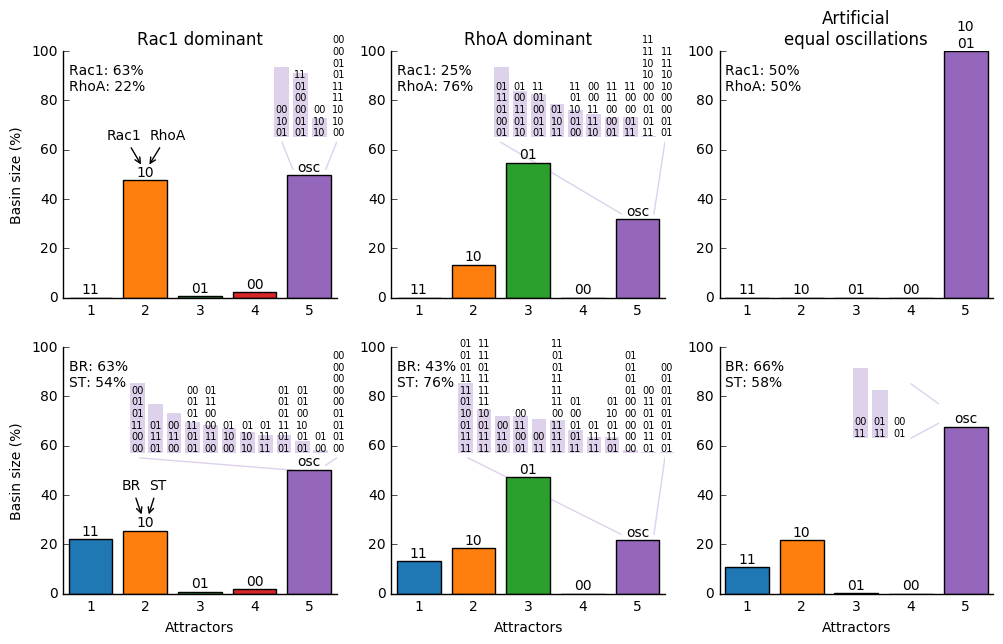

In [67]:
osc_color = '#ded1eb'


def plot_basins(ax, basins, values, acts, labels = None):    
    
    if labels == None:
        labels = range(1, 1+len(values))
    
    bar_color = colors[0];

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')
    pl.setp(ax.get_yticklabels(), visible=True)

    ax.bar(range(1, len(values)+1), values, align='center', antialiased=True, edgecolor='black', color=colors)
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels)

    font = {'weight':'normal',
            'family': 'sans-serif'}
    for idx, basin in enumerate(basins):
        ax.text(idx+1, values[idx] + 0.5, basin, fontdict=font, ha='center', va='bottom')
        
    ax.set_xlim((0.5, 5.5))    
    
def plot_oscillations(ax, basins, values):
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.set_xlim((-0.4, 8.4))
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.bar(range(len(values)), values, 
           align='center', antialiased=True, edgecolor='gray', 
           color=osc_color, width=0.8, linewidth=0)

    for i, basin in enumerate(basins):        
        ax.text(i, 0.0, basin, ha='center', va='bottom', fontsize=7)
            
    ax.set_frame_on(False)


fig, axes = pl.subplots(2, 3, sharey=True, figsize = (12, 7))


for idx in range(3):
    plot_basins(axes[0, idx], 
            data[idx]['Rt']['basins'], 
            data[idx]['Rt']['values'],               
            'Rac1: {}%\nRhoA: {}%'.format(activities[idx]['Rac1'], activities[idx]['RhoA']))   

    axes[0, idx].set_title(titles[idx], y=1.0)
    axes[0, idx].text(0.6, 95, 
                      'Rac1: {}%\nRhoA: {}%'.format(activities[idx]['Rac1'], activities[idx]['RhoA']), 
                      horizontalalignment='left',
                      verticalalignment='top')
        
    w = len(data[idx]['Ro']['basins']) * 0.18
    
    if idx != 2:
        if idx == 0:
            bbox = (1.05, 0.95)
        elif idx == 1:
            bbox = (1.05, 0.95)
        
        ax = inset_axes(axes[0,idx], width=w, height=0.7, loc=1, borderpad=0.25,
            bbox_to_anchor=bbox,
            bbox_transform=axes[0,idx].transAxes)
        plot_oscillations(ax, data[idx]['Ro']['basins'], data[idx]['Ro']['values'])
    
    plot_basins(axes[1, idx], 
            data[idx]['At']['basins'], 
            data[idx]['At']['values'],
            'Actin BR: {}%\nActin ST: {}%'.format(activities[idx]['Actin_BR'], activities[idx]['Actin_ST']))   
    
    axes[1, idx].set_xlabel('Attractors')
    axes[1, idx].text(0.6, 95, 
                      'BR: {}%\nST: {}%'.format(activities[idx]['Actin_BR'], activities[idx]['Actin_ST']), 
                      horizontalalignment='left',
                      verticalalignment='top')
    
    if idx == 0:
        bbox = (1.05, 0.87)
    elif idx == 1:
        bbox = (1.05, 0.87)
    elif idx == 2:
        bbox = (0.7, 0.93)
    
    w = len(data[idx]['Ao']['basins']) * 0.18
    
    ax = inset_axes(axes[1,idx], width=w, height=0.7, loc=1, borderpad=0.25, 
        bbox_to_anchor=bbox,
        bbox_transform=axes[1,idx].transAxes)
        
    plot_oscillations(ax, data[idx]['Ao']['basins'], data[idx]['Ao']['values'])
    
    
    
    
axes[0, 0].set_ylabel('Basin size (%)')
axes[1, 0].set_ylabel('Basin size (%)')
      
add_annotation(axes[0,0], ('Rac1', 'RhoA'), 2, 53)
add_annotation(axes[1,0], ('BR', 'ST'), 2, 31)


axes[0,0].plot([5.3, 5.5], [52, 63], color=osc_color)
axes[0,0].plot([4.7, 4.5], [52, 63], color=osc_color)

axes[0,1].plot([5.3, 5.5], [34, 63], color=osc_color)
axes[0,1].plot([4.7, 2.5], [34, 63], color=osc_color, zorder=-1)

axes[1,0].plot([5.3, 5.5], [52, 55], color=osc_color)
axes[1,0].plot([4.7, 1.9], [50, 55], color=osc_color, zorder=-1)

axes[1,1].plot([5.3, 5.5], [24, 55], color=osc_color)
axes[1,1].plot([4.7, 1.9], [24, 55], color=osc_color, zorder=-1)

axes[1,2].plot([4.5, 4.0], [69, 63], color=osc_color)
axes[1,2].plot([4.5, 4.0], [77, 85], color=osc_color)


fig.savefig('charts/fig_2_d.svg', bbox_inches='tight')
fig.savefig('charts/fig_2_d.png', bbox_inches='tight', dpi=300)